In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '..'))
from symlie.misc.viz import plot2d

from symlie.misc.utils_results import pivot, assert_columns_same, get_and_check_Ps, stringify_dict, aggregate_dataset, plot_best, return_table
from symlie.misc.wandb import update_results_df, get_inspect_df
from symlie.model.setup import load_P_pred

/scratch-local/eliasd/ipykernel_338825/1209110561.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [22]:
# Select dataframe to analyze
check_df = 'results'
reload = False

# check_df = 'inspect'
# reload = True

match check_df:
    case 'results':
        if reload:
            update_results_df()
        df = pd.read_pickle('../logs/store/results_df.pkl')
        plot_single_pivot = False
    case 'inspect':
        df_inspect = get_inspect_df(reload = reload)
        df = df_inspect
        plot_single_pivot = True

print(df.shape)

(579, 49)


In [23]:
df

,lr,net,bias,name,seed,tags,test,A_low,n_val,train,...,args_processed,do_return_model,n_hidden_layers,transform_kwargs,use_P_from_noise,persistent_workers,run_name,test_loss,n_classes,svd_rank
0,0.010,TrainP,False,None,3,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,dandy-donkey-1960,6.474450e-05,NaN,NaN
1,0.001,TrainP,False,None,3,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,swept-lion-1959,3.812419e-02,NaN,NaN
2,0.100,TrainP,False,None,3,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,atomic-planet-1958,1.422213e-07,NaN,NaN
3,0.001,TrainP,False,None,2,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,royal-mountain-1957,3.862118e-02,NaN,NaN
4,0.100,TrainP,False,None,2,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0, 1, 1, 1], 'only_flip': False}",False,True,glamorous-snowflake-1955,1.425501e-07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,0.100,TrainP,False,None,1,"[inspect, new, noise, svd]",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",False,True,eager-firefly-2213,1.208998e-14,None,14.0
575,0.010,TrainP,False,None,1,"[inspect, new, noise, svd]",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",False,True,toasty-paper-2213,7.349598e-02,None,3.0
576,0.100,TrainP,False,None,1,"[inspect, new, noise, svd]",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",False,True,pleasant-pine-2213,9.551645e-12,None,30.0
577,0.100,TrainP,False,None,1,"[inspect, new, noise, svd]",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",False,True,devoted-firefly-2212,4.830418e-15,None,7.0


dataset_name='noise', group=('[0, 0, 1, 0]', '1.0'), hparams_min=('test_loss', 0.1, 7.0)


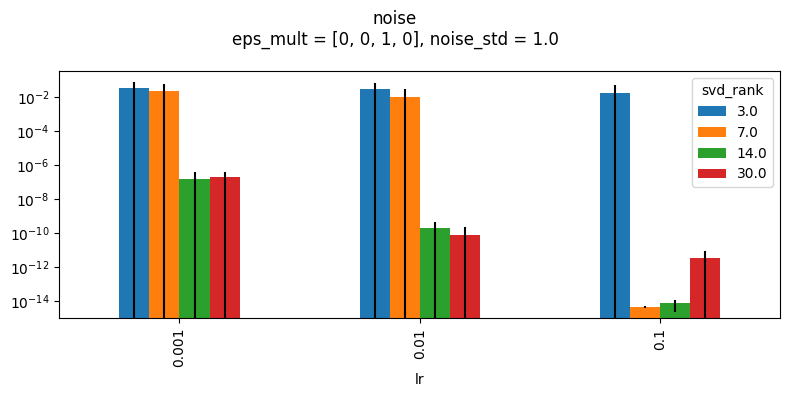

dataset_name='noise', group=('[0, 0, 1, 1]', '1.0'), hparams_min=('test_loss', 0.1, nan)


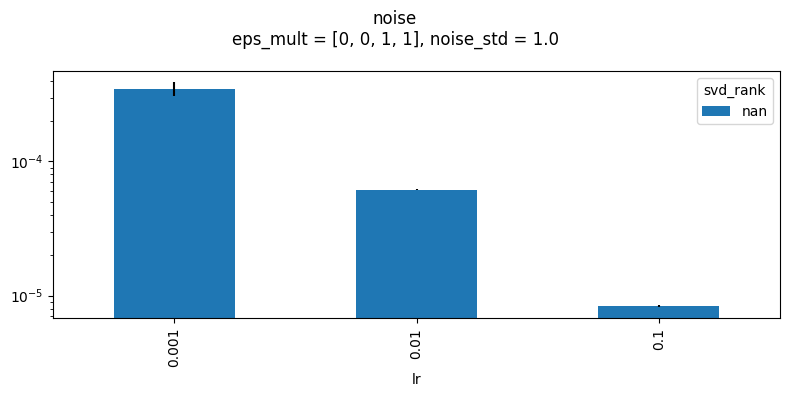

dataset_name='noise', group=('[0, 1, 1, 1]', '1.0'), hparams_min=('test_loss', 0.1, nan)


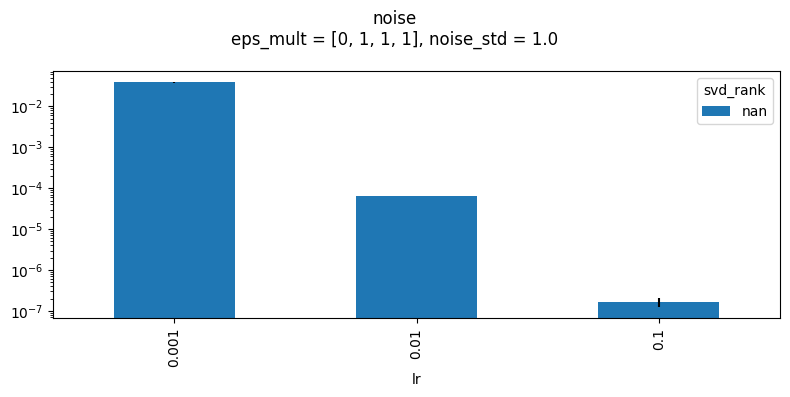

In [24]:
# Select step to analyze
step = 1
# step = 2

datasets_new = [
    # 'sine1d',
    # 'sine2d',
    # 'flower',
    # 'mnist',
    'noise'
]

datasets_inspect = [
    # 'sine1d-noise',
    # 'sine1dlayers',
    # 'sine1dtwo-hparam',
    'noise'
]
datasets = {'results' : datasets_new, 'inspect' : datasets_inspect}[check_df]

default_log = [
    'noise',
    'sine2d',
    # 'flower',
]

group_params = ['eps_mult', 'noise_std']
hyper_params  = ['n_train', 'lr', 'svd_rank', 'net'] if step == 2 else ['lr', 'svd_rank']

d_pivots, ddd, ddd_mean, ddd_std, mins = aggregate_dataset(
    datasets=datasets,
    df = df,
    step = step,
    group_params = group_params,
    hyper_params = hyper_params,
    check_df=check_df,
    default_log=default_log,
    plot_single_pivot=True,
)

In [25]:
if step == 2:
    plot_best(ddd_mean, ddd_std)
return_table(df, step, group_params, hyper_params)

test_loss                          \
lr                                        0.001                           
svd_rank                                   3.0                            
seed                                          1             2         3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0             NaN           NaN       NaN   
                            0.1             NaN           NaN       NaN   
../data/flower [0, 0, 1, 1] 0.0             NaN           NaN       NaN   
                            0.1             NaN           NaN       NaN   
               [0, 1, 1, 1] 0.0             NaN           NaN       NaN   
                            0.1             NaN           NaN       NaN   
../data/noise  [0, 0, 1, 0] 1.0        0.076846  2.919860e-14  0.033282   
               [0, 0, 1, 1] 1.0             NaN           NaN       NaN   
               [0, 1, 1, 1] 1.0             NaN           NaN       NaN   
../data/sine1d [0, 0, 1, 0] 0.5             NaN           NaN       NaN   
../data/sine2d [0, 0, 1, 1] 0.1             NaN           NaN       NaN   
               [0, 1, 1, 1] 0.1             NaN           NaN       NaN   

                                                                             \
lr                                                                            
svd_rank                                       7.0                            
seed                                              1             2         3   
data_dir       eps_mult     noise_std                                         
../data/MNIST  [0, 1, 1, 1] 0.0                 NaN           NaN       NaN   
                            0.1                 NaN           NaN       NaN   
../data/flower [0, 0, 1, 1] 0.0                 NaN           NaN       NaN   
                            0.1                 NaN           NaN       NaN   
               [0, 1, 1, 1] 0.0                 NaN           NaN       NaN   
                            0.1                 NaN           NaN       NaN   
../data/noise  [0, 0, 1, 0] 1.0        1.788519e-10  2.148148e-07  0.068766   
               [0, 0, 1, 1] 1.0                 NaN           NaN       NaN   
               [0, 1, 1, 1] 1.0                 NaN           NaN       NaN   
../data/sine1d [0, 0, 1, 0] 0.5                 NaN           NaN       NaN   
../data/sine2d [0, 0, 1, 1] 0.1                 NaN           NaN       NaN   
               [0, 1, 1, 1] 0.1                 NaN           NaN       NaN   

                                                                   \
lr                                                                  
svd_rank                                       14.0                 
seed                                              1             2   
data_dir       eps_mult     noise_std                               
../data/MNIST  [0, 1, 1, 1] 0.0                 NaN           NaN   
                            0.1                 NaN           NaN   
../data/flower [0, 0, 1, 1] 0.0                 NaN           NaN   
                            0.1                 NaN           NaN   
               [0, 1, 1, 1] 0.0                 NaN           NaN   
                            0.1                 NaN           NaN   
../data/noise  [0, 0, 1, 0] 1.0        4.305833e-07  1.852233e-08   
               [0, 0, 1, 1] 1.0                 NaN           NaN   
               [0, 1, 1, 1] 1.0                 NaN           NaN   
../data/sine1d [0, 0, 1, 0] 0.5                 NaN           NaN   
../data/sine2d [0, 0, 1, 1] 0.1                 NaN           NaN   
               [0, 1, 1, 1] 0.1                 NaN           NaN   

                                                                   ...  \
lr                                                                 ...   
svd_rank                                                     30.0  ...   
seed                  

# Map

In [26]:
assert step == 1

In [27]:
def filter_on_tags(df, tags):
    return df[df['tags'].astype(str).str.contains('|'.join(tags))]

In [28]:
df_map = pd.read_pickle('../logs/store/map_df.pkl')

df_map_sync = filter_on_tags(df_map, tags = ['sine1d', 'noise'])
df_map_sync = df_map_sync.reset_index(drop=True)
df_map_sync

,run_id,tags,data_kwargs,transform_kwargs,seed,data_dir,svd_rank
0,3gi8lu9g,"[new, sine1d]","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",3,../data/sine1d,NaN
1,lh3nnnij,"[new, sine1d]","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",2,../data/sine1d,NaN
2,cpw6d6pz,"[new, sine1d]","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",1,../data/sine1d,NaN
3,vjewun0b,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",3,../data/noise,NaN
4,g41hidqj,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",2,../data/noise,NaN
5,xxidyaps,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",1,../data/noise,NaN
6,5qbdclqh,"[new, noise]","{'grid_size': (7, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 1.0], 'only_flip'...",3,../data/noise,NaN
7,jb4gxwpb,"[new, noise]","{'grid_size': (7, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 1.0], 'only_flip'...",2,../data/noise,NaN
8,o7w74teb,"[new, noise]","{'grid_size': (7, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 1.0], 'only_flip'...",1,../data/noise,NaN
9,6pb0nn34,"[new, noise]","{'grid_size': (7, 7), 'noise_std': 1}","{'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip'...",3,../data/noise,NaN


In [29]:
sync_run_ids = list(df_map_sync['run_id'].values)

store_dir = '../logs/store'
# write the run_ids to a txt file
with open(os.path.join(store_dir, 'sync_run_ids.txt'), 'w') as f:
    f.write(f"{{{','.join(sync_run_ids)}}}")

# Let's check P's

In [30]:
df

,lr,net,bias,name,seed,tags,test,A_low,n_val,train,...,args_processed,do_return_model,n_hidden_layers,transform_kwargs,use_P_from_noise,persistent_workers,run_name,test_loss,n_classes,svd_rank
0,0.010,TrainP,False,None,3,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip'...",False,True,dandy-donkey-1960,6.474450e-05,NaN,NaN
1,0.001,TrainP,False,None,3,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip'...",False,True,swept-lion-1959,3.812419e-02,NaN,NaN
2,0.100,TrainP,False,None,3,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip'...",False,True,atomic-planet-1958,1.422213e-07,NaN,NaN
3,0.001,TrainP,False,None,2,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip'...",False,True,royal-mountain-1957,3.862118e-02,NaN,NaN
4,0.100,TrainP,False,None,2,"[new, noise]",True,NaN,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 1.0, 1.0, 1.0], 'only_flip'...",False,True,glamorous-snowflake-1955,1.425501e-07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,0.100,TrainP,False,None,1,"[inspect, new, noise, svd]",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",False,True,eager-firefly-2213,1.208998e-14,None,14.0
575,0.010,TrainP,False,None,1,"[inspect, new, noise, svd]",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",False,True,toasty-paper-2213,7.349598e-02,None,3.0
576,0.100,TrainP,False,None,1,"[inspect, new, noise, svd]",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",False,True,pleasant-pine-2213,9.551645e-12,None,30.0
577,0.100,TrainP,False,None,1,"[inspect, new, noise, svd]",True,None,1000,True,...,True,False,1.0,"{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",False,True,devoted-firefly-2212,4.830418e-15,None,7.0


In [45]:
# Select df
d = df_map_sync
# d = df_map
# d = df

# Filter d
d = filter_on_tags(d, tags = ['noise'])
transform_kwargs = {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False}
d = d[d['transform_kwargs'] == transform_kwargs]
d = d[d['svd_rank'] == 3]
map_kwargs = assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir', 'svd_rank'])
print(f'map_kwargs = {map_kwargs}')

seeds = d['seed'].unique()
n_d = len(d)
assert len(seeds) == n_d, f'seeds={seeds}, n_d={n_d}'
print(f'seeds={seeds}')

map_kwargs = {'data_kwargs': {'grid_size': (1, 7), 'noise_std': 1}, 'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False}, 'data_dir': '../data/noise', 'svd_rank': 3.0}
seeds=[3 2 1]


Found run_id uutj0wk7
Found run_id ghhrf8d0
Found run_id ep9fxvi5


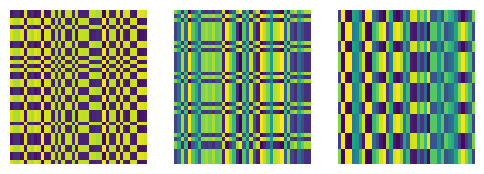

In [46]:
Ps = get_and_check_Ps(seeds, map_kwargs, use_P_from_noise = True)
# Ps = get_and_check_Ps([1], map_kwargs)
plot2d(Ps, l = 2, max_grid = 40)

In [15]:
import torch

from symlie.model.networks.implicit import LinearImplicit

In [1]:
linear_implicit = LinearImplicit(
    in_features = 7, 
    out_features = 7,
    bias = False,
    hidden_implicit_layers = [49, 49],
)

implicit_statedict = torch.load('../logs/store/implicit_P/otnoxw0l.pt')
# linear_implicit.implicit_P.load_state_dict(implicit_statedict)

linear_implicit.eval()

NameError: name 'LinearImplicit' is not defined

In [30]:
x = torch.randn((1,7))
x.shape

torch.Size([1, 7])

In [31]:
linear_implicit(x)

tensor([[ 0.0080,  0.0532,  0.0000,  0.3132,  0.3418, -0.1157,  0.1974]],
       grad_fn=<MmBackward0>)